In [51]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
plt.style.use('fivethirtyeight')
from google.cloud import storage
import os
import datetime
from io import BytesIO

**Importing the dataset**

In [3]:
bucket_name = "project_bucket_big_data" 
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

# TODO: Specify the file name for blob object
blob = storage.blob.Blob("US_Accidents_Dec19.csv",bucket)

# Convert to string
content = blob.download_as_string()

# Create a pandas dataframe
# First for Descriptive Analytics
descriptive_df = pd.read_csv(BytesIO(content))
# Second for preprocessing and Machine Learning
ML_df = pd.read_csv(BytesIO(content))

# Descriptive Analytics

**Scatter Plot Map of Severity per Location**

No handles with labels found to put in legend.


<Figure size 1440x720 with 0 Axes>

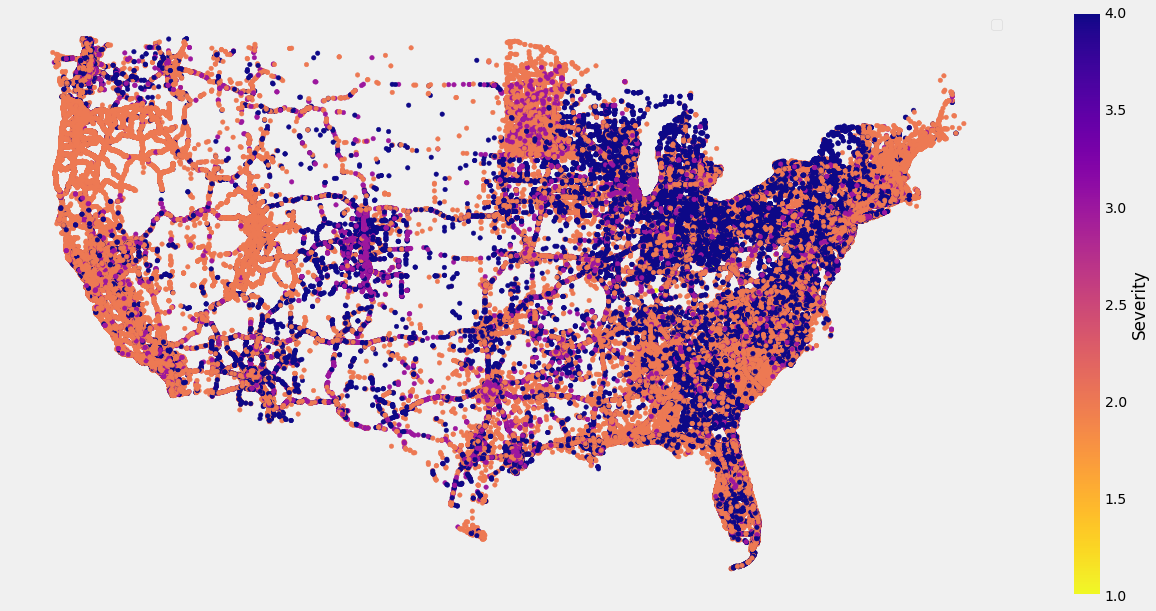

In [31]:
plt.figure(figsize=(20,10))
severity_map = descriptive_df.plot(kind='scatter', x='Start_Lng',y='Start_Lat',c='Severity',cmap=plt.get_cmap('plasma_r'), figsize=(20,10))
severity_map.legend()
plt.grid(False)
plt.xticks(ticks=None, labels=None)
plt.yticks(ticks=None, labels=None)
plt.xlabel('')
plt.ylabel('')
plt.axis('off')
plt.rcParams['savefig.facecolor']='white'
plt.savefig('Map.png', bbox_inches='tight')

**Plot of Severity Distribution**

No handles with labels found to put in legend.
/home/rwaffle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


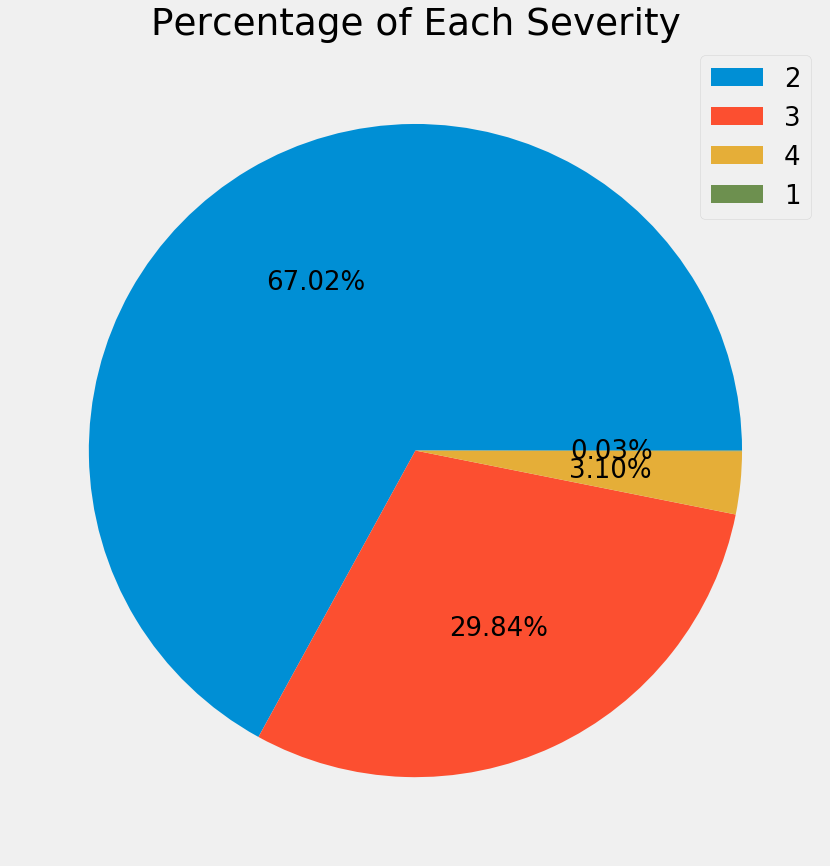

In [41]:
# Creating pie chart and bar chart to show percentage and count of each severity type
plt.figure(figsize=(14,14))
plt.legend()
descriptive_df['Severity'].value_counts().plot.pie(autopct='%1.2f%%', labels = None, legend = True)
plt.axes().set_ylabel('')
plt.title('Percentage of Each Severity')
plt.rcParams.update({'font.size': 26})
plt.rcParams['savefig.facecolor']='white'
plt.savefig('Severitypie.png')

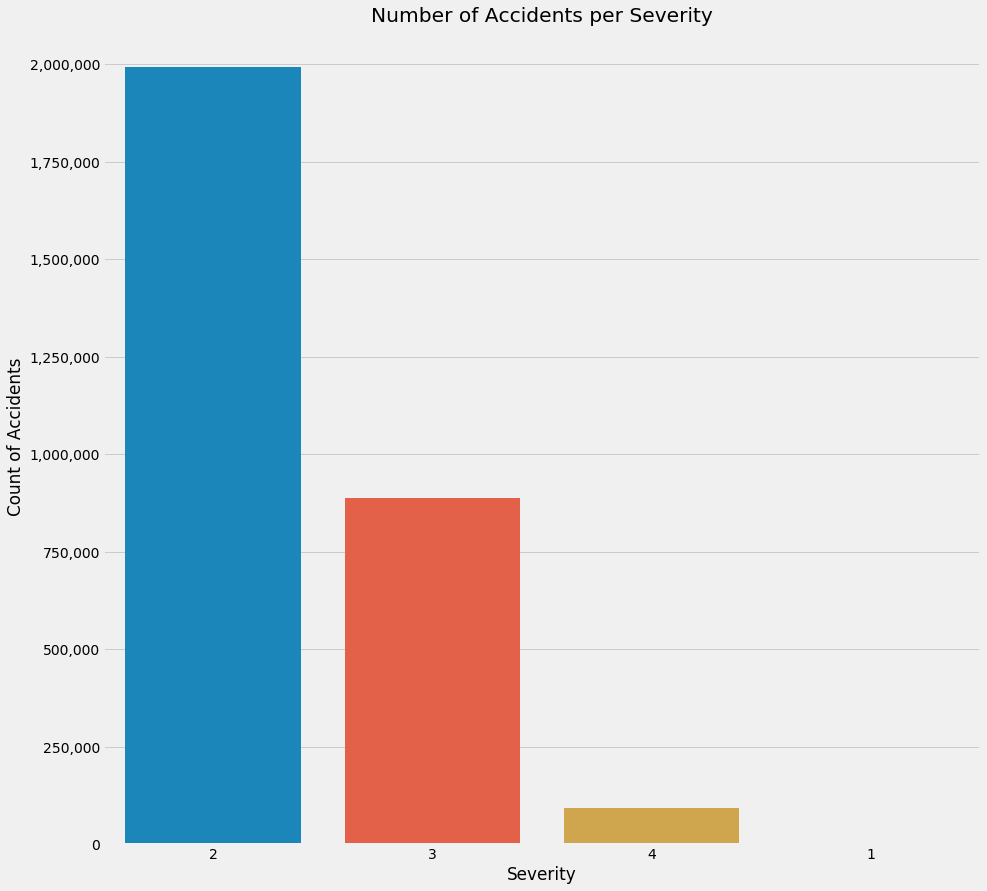

In [53]:
plt.figure(figsize=(14,14))
plt.rcParams['savefig.facecolor']='white'
c_plot = sns.countplot('Severity',data=descriptive_df,order=descriptive_df['Severity'].value_counts().index)
c_plot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Number of Accidents per Severity')
plt.ylabel('Count of Accidents')
plt.savefig('Severitybar.png', bbox_inches='tight')

**Accidents by Weather Condition**

/home/rwaffle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


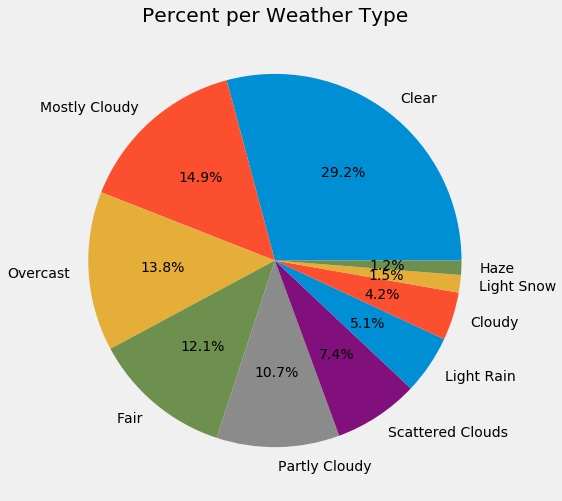

In [55]:
# Creating pie chart show percentage of each weather type
plt.figure(figsize=(14,8))
descriptive_df.groupby('Weather_Condition').size().sort_values(ascending = False).iloc[:10].plot.pie(autopct='%1.1f%%')
plt.axes().set_ylabel('')
plt.title('Percent per Weather Type')
plt.savefig('Weather.png', bbox_inches='tight')

**Plot of Proximity to Traffic Objects**

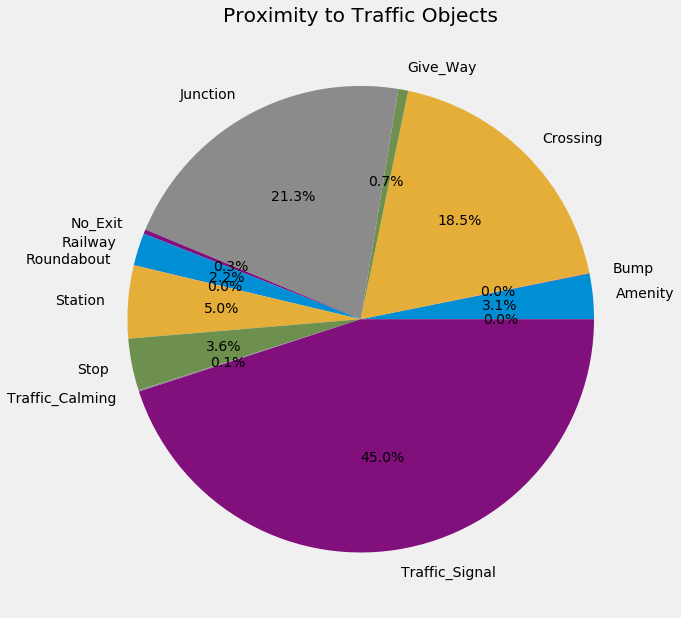

In [56]:
# Find Columns where the data type is bool
objects = [col for col in descriptive_df.columns if descriptive_df[col].dtype == np.dtype('bool')]

# Create a dataframe with only those columns
objectsdf = descriptive_df[objects]

# Add up the number of True bools per column and plot to a pie chart
traffic_objects = objectsdf.sum(axis=0)
traffic_objects.plot.pie(autopct='%1.1f%%',shadow=False,figsize=(10,10))
plt.ylabel('')
plt.title('Proximity to Traffic Objects')
plt.rcParams['savefig.facecolor']='white'
plt.savefig('Object.png', bbox_inches='tight')

# **Data Cleaning for Machine Learning**

In [60]:
# Convert time columns to datetime
ML_df['Start_Time'] = pd.to_datetime(ML_df['Start_Time'], errors='coerce')
ML_df['End_Time'] = pd.to_datetime(ML_df['End_Time'], errors='coerce')

# Extract info from datetime
ML_df['Month']=ML_df['Start_Time'].dt.strftime('%b')
ML_df['Hour']=ML_df['Start_Time'].dt.hour
ML_df['Weekday']=ML_df['Start_Time'].dt.strftime('%a')

# Figure out duration of accident by subracting start time from end time
duration='Time_Duration(min)'
ML_df[duration]=round((ML_df['End_Time']-ML_df['Start_Time'])/np.timedelta64(1,'m'))

# Drop any rows with duration<0
neg_outliers=ML_df[duration]<=0

# Set any outliers to NAN
ML_df[neg_outliers] = np.nan

# Drop rows with negative duration
ML_df.dropna(subset=[duration],axis=0,inplace=True)

**Correlation Matrix**

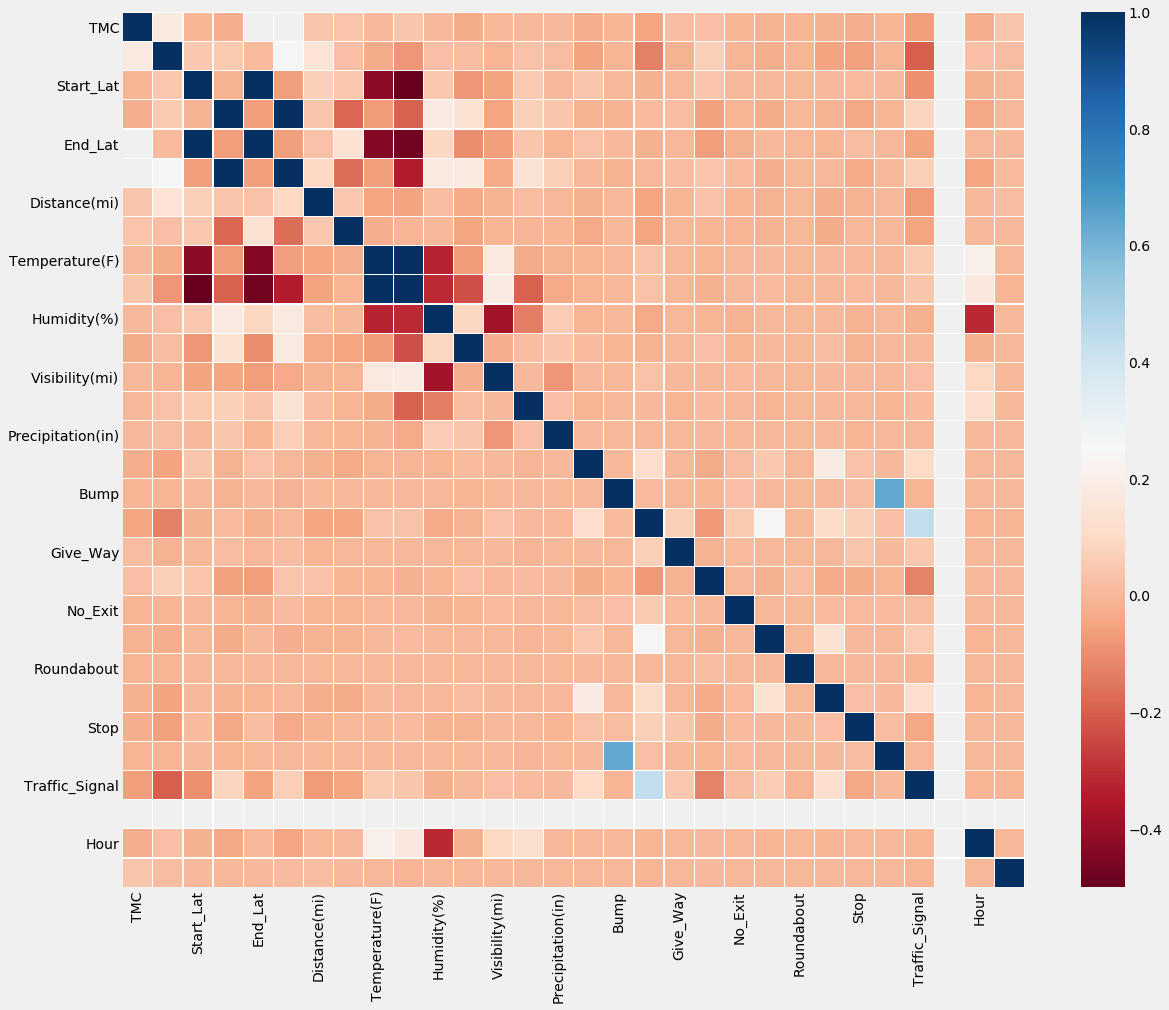

In [83]:
# Creating Correlation Matrix for all Variables
fig=sns.heatmap(ML_df.corr(),annot=False,cmap='RdBu',linewidths=0.1, vmin=-.5, vmax=1)
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.rcParams['savefig.facecolor'] = 'white'
plt.savefig('Correlation.png', bbox_inches='tight')

**Removing Columns with too many Missing Values**

In [8]:
# Create new df to determine how many missing values per column
missing_values = ML_df.isnull().sum(axis=0).reset_index()
missing_values.columns = ['columns_name','missing_count']
missing_values['missing_percentage'] = missing_values['missing_count'] /ML_df.shape[0]
missing_values.loc[missing_values['missing_percentage']>0.60]

# Determine which columns should be removed if they have more than 60% missing values
missing = missing_values.loc[missing_values['missing_percentage']>.6]
removelist = missing['columns_name'].tolist()
removelist

,columns_name,missing_count,missing_percentage
8,End_Lat,2246246,0.755215
9,End_Lng,2246246,0.755215
12,Number,1917591,0.644717
24,Wind_Chill(F),1852611,0.622870
30,Precipitation(in),1998347,0.671868


**Dropping Rows with many Missing Values**

In [40]:
# Isolate only the features we want to use based on correlation and removelist
features=['Source','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

# Select the dataset to include only the selected features
ML_df_final=ML_df[features].copy()
# Drop rows in columns with null values so that the mean of the column based on True or False is = 0
ML_df_final.dropna(subset=df_sel.columns[ML_df_final.isnull().mean()!=0], how='any', axis=0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2974313 entries, 0 to 2974334
Data columns (total 33 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Source              object 
 1   Severity            float64
 2   Start_Lng           float64
 3   Start_Lat           float64
 4   Distance(mi)        float64
 5   Side                object 
 6   City                object 
 7   County              object 
 8   State               object 
 9   Timezone            object 
 10  Temperature(F)      float64
 11  Humidity(%)         float64
 12  Pressure(in)        float64
 13  Visibility(mi)      float64
 14  Wind_Direction      object 
 15  Weather_Condition   object 
 16  Amenity             float64
 17  Bump                float64
 18  Crossing            float64
 19  Give_Way            float64
 20  Junction            float64
 21  No_Exit             float64
 22  Railway             float64
 23  Roundabout          float64
 24  Station             floa

In [34]:
#Save to CSV File for Machine Learning
ML_df_final.to_csv('Traffic_Dataset.csv', sep = '|', index = False)